### ***MODEL 1***

<ipython-input-26-34418bd5c5d4>:24: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  data = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]


Epoch 1/50
16/16 [==============================] - 1s 16ms/step - loss: 1.3467 - accuracy: 0.4841 - val_loss: 0.9187 - val_accuracy: 0.5179
Epoch 2/50
16/16 [==============================] - 0s 6ms/step - loss: 1.0762 - accuracy: 0.5199 - val_loss: 0.8415 - val_accuracy: 0.6429
Epoch 3/50
16/16 [==============================] - 0s 4ms/step - loss: 0.9555 - accuracy: 0.5458 - val_loss: 0.8096 - val_accuracy: 0.6964
Epoch 4/50
16/16 [==============================] - 0s 5ms/step - loss: 0.8979 - accuracy: 0.5598 - val_loss: 0.7707 - val_accuracy: 0.6250
Epoch 5/50
16/16 [==============================] - 0s 6ms/step - loss: 0.8925 - accuracy: 0.5558 - val_loss: 0.7663 - val_accuracy: 0.5893
Epoch 6/50
16/16 [==============================] - 0s 6ms/step - loss: 0.8272 - accuracy: 0.6056 - val_loss: 0.7458 - val_accuracy: 0.6786
Epoch 7/50
16/16 [==============================] - 0s 5ms/step - loss: 0.8001 - accuracy: 0.5797 - val_loss: 0.7119 - val_accuracy: 0.6964
Epoch 8/50
16/16 [=

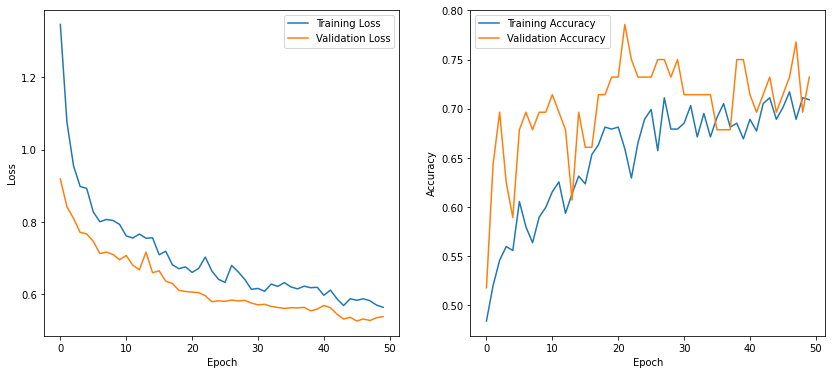

1/1 [==============================] - 0s 186ms/step
['low risk']
2/2 [==============================] - 0s 10ms/step
Confusion Matrix:
[[ 5  1  0]
 [ 0 28  3]
 [ 0 15 10]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.64      0.90      0.75        31
           2       0.77      0.40      0.53        25

    accuracy                           0.69        62
   macro avg       0.80      0.71      0.73        62
weighted avg       0.73      0.69      0.67        62



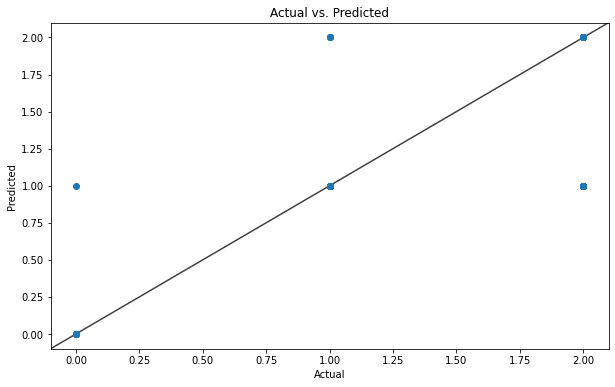

In [26]:
from numpy.lib.index_tricks import diag_indices
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras as keras
from sklearn.metrics import confusion_matrix, classification_report

# Load the dataset
data = pd.read_csv("AIData.csv")

# Data cleaning
data = data.dropna()

# IQR METHOD REMOVE ANOMALIES
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
data = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]

# Target and Feature Variables
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Encode the variables
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

 #data split into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42) #10% data for tsting 

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ANN MODEL
model = keras.Sequential([ #Uses Keras Library
    keras.layers.Dense(units=64, activation='relu', kernel_initializer='he_normal', input_shape=(6,)),
    Dropout(0.2), #dropout value of 0.2
    keras.layers.Dense(units=128, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.2),
    keras.layers.Dense(units=64, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.2),
    keras.layers.Dense(units=32, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.2),
    keras.layers.Dense(units=3, activation='softmax') #dense layers
])

# Compiled using adam optimiser
aoptimiser = keras.optimizers.Adam(learning_rate=0.001) #0.001 learning rate
model.compile(optimizer=aoptimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Early stopping to prevent overfitting
estopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) #early stopping after 10 epoch

# Model training
hist = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[estopping]) #50 epochs and batch size 32

# Plot training and validation loss and accuracy
plt.figure(figsize=(14, 6))

# Training loss against validation loss
plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], label='Training Loss') #plotting training loss
plt.plot(hist.history['val_loss'], label='Validation Loss') #plotting validation loss
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# training accuracy against validation accuracy
plt.subplot(1, 2, 2)
plt.plot(hist.history['accuracy'], label='Training Accuracy') #plotting training accuracy
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy') #plotting validation accuracy
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Model evaluation
test_loss, test_acc = model.evaluate(X_test, y_test)

# Model making predictions
testdata = scaler.transform(np.array([[27, 120, 80, 7.5, 98.6, 85]]))
predicts = model.predict(testdata) #make predictions
labelPredicted = label_encoder.inverse_transform([np.argmax(predicts)])
print(labelPredicted) #print predictions

# make predictions on test set
ypredictedprobability = model.predict(X_test)
y_pred = np.argmax(ypredictedprobability, axis=1)

# Calculate the confusion matrix
confmatrix = confusion_matrix(y_test, y_pred)

# Create the classification report
classreport = classification_report(y_test, y_pred)

# Print the confusion matrix and classification report
print("Confusion Matrix:")
print(confmatrix)
print("\nClassification Report:")
print(classreport)

#-----------------------------------------------------------------------------
# Scatter plot comparing predictions and actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred) #predictions
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')

# Diagonal line to visualise actual
diag = [np.min([plt.xlim(), plt.ylim()]), np.max([plt.xlim(), plt.ylim()])]
plt.plot(diag, diag, 'k-', alpha=0.75, zorder=0) #creating format
plt.xlim(diag) 
plt.ylim(diag)

plt.show()

### MODEL **2**

<ipython-input-31-dca8a19bf3e3>:15: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  data = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]


Accuracy: 0.8145161290322581
Confusion Matrix:
[[10  1  0]
 [ 0 52 12]
 [ 0 10 39]]

Classification Report:
              precision    recall  f1-score   support

   high risk       1.00      0.91      0.95        11
    low risk       0.83      0.81      0.82        64
    mid risk       0.76      0.80      0.78        49

    accuracy                           0.81       124
   macro avg       0.86      0.84      0.85       124
weighted avg       0.82      0.81      0.82       124



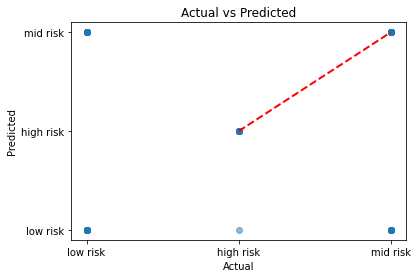

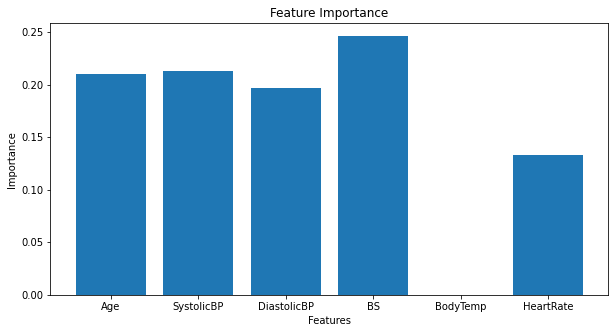

In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# load the dataset
data = pd.read_csv("AIData.csv")

# Removing anomalies using IQR
Q1 = data.quantile(0.25) #lower quartile
Q3 = data.quantile(0.75) #upper quartile
IQR = Q3 - Q1 
data = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]

# target and feature variables creation
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# training and testing datasets split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #20% of dataset for testing

# Feature Scaling
scaler = StandardScaler() 
X_train = scaler.fit_transform(X_train) #training
X_test = scaler.transform(X_test)  #testing

# random forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# training model
model.fit(X_train, y_train)

# testing data make predictions
predictionsy = model.predict(X_test) #test set

# evaluate and print model accuracy
scoreaccu = accuracy_score(y_test, predictionsy)
print("Accuracy:", scoreaccu)

# create confusion and classification matrix
confusmatrix = confusion_matrix(y_test, predictionsy)
classreport = classification_report(y_test, predictionsy)

# print confusion and classification matrix
print("Confusion Matrix:")
print(confusmatrix)
print("\nClassification Report:")
print(classreport)

# scatter plot compare prefictions and actual
plt.scatter(y_test, predictionsy, alpha=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', lw=2)
plt.show()

# Feature importance plot
importplot = model.feature_importances_
namfeatures = data.columns[:-1]

plt.figure(figsize=(10, 5))
plt.bar(namfeatures, importplot)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()






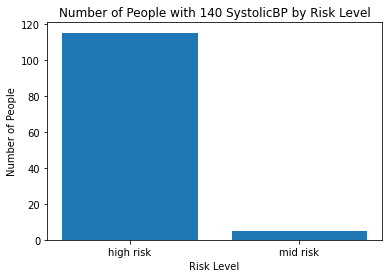

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv("AIData.csv")

# data cleaning
data = data.dropna()  # Remove missing values
data = data[data['SystolicBP'] == 140]  # Filter people with SystolicBP equal to 140

# Group the data by risk level and count the number of people
countrisklevel = data['RiskLevel'].value_counts()

# Visualise the bar chart
plt.bar(countrisklevel.index, countrisklevel.values)
plt.xlabel("Risk Level") # axis
plt.ylabel("Number of People")
plt.title("Number of People with 140 SystolicBP by Risk Level")
plt.show()


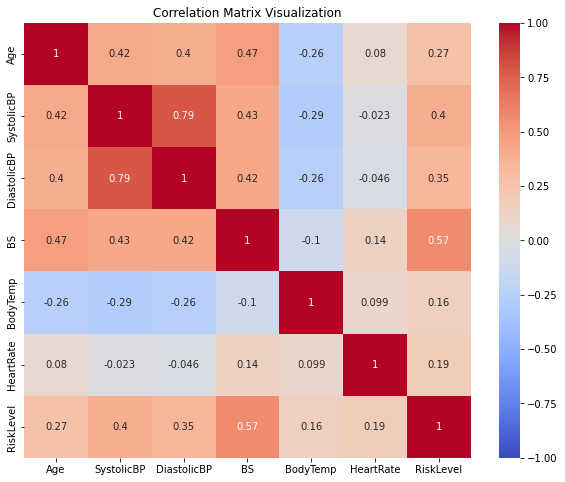

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv("AIData.csv")

# data cleaning
data = data.dropna()  # drops rows with null values

# risk levels shown as values
maprisklevel = {'low risk': 0, 'mid risk': 1, 'high risk': 2} #map values
data['RiskLevel'] = data['RiskLevel'].map(maprisklevel) 

# correlation matrix
corrematrix = data.corr()

# visualise as heatmap
plt.figure(figsize=(10, 8)) # format for map
sns.heatmap(corrematrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1) #heatmap
plt.title("Correlation Matrix Visualization")
plt.show()


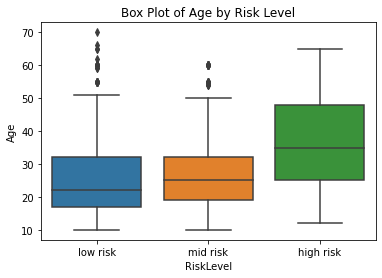

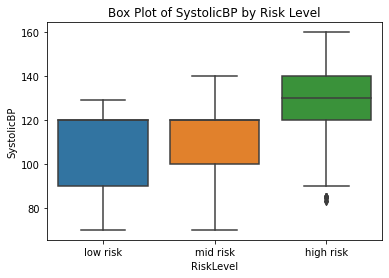

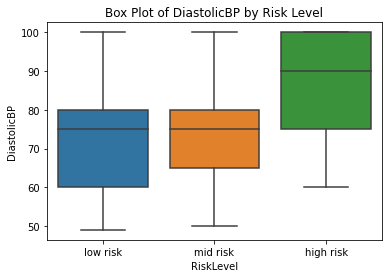

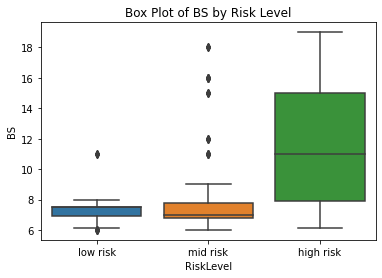

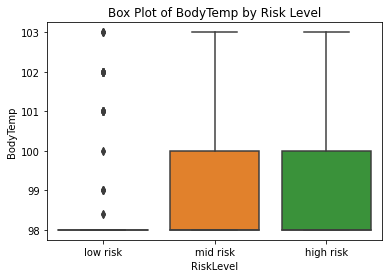

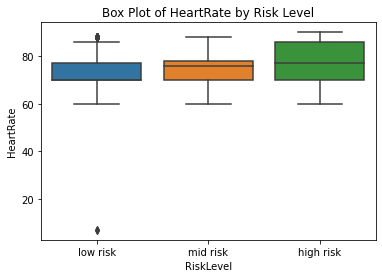

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the data
data = pd.read_csv("AIData.csv")

# Data Cleaning
maprisklevel = {'low risk': 0, 'mid risk': 1, 'high risk': 2} #Encoding Risk level as number
data['RiskLevel'] = data['RiskLevel'].map(maprisklevel)

# box plot for every feature
features = data.select_dtypes(include=np.number).columns.tolist()
features.remove('RiskLevel') #get rid of risk level

for feature in features:
    sns.boxplot(x='RiskLevel', y=feature, data=data) #D
    plt.xticks(ticks=[0, 1, 2], labels=['low risk', 'mid risk', 'high risk']) #labels for graph
    plt.title(f"Box Plot of {feature} by Risk Level") #compare all features with risk
    plt.show() #display chart





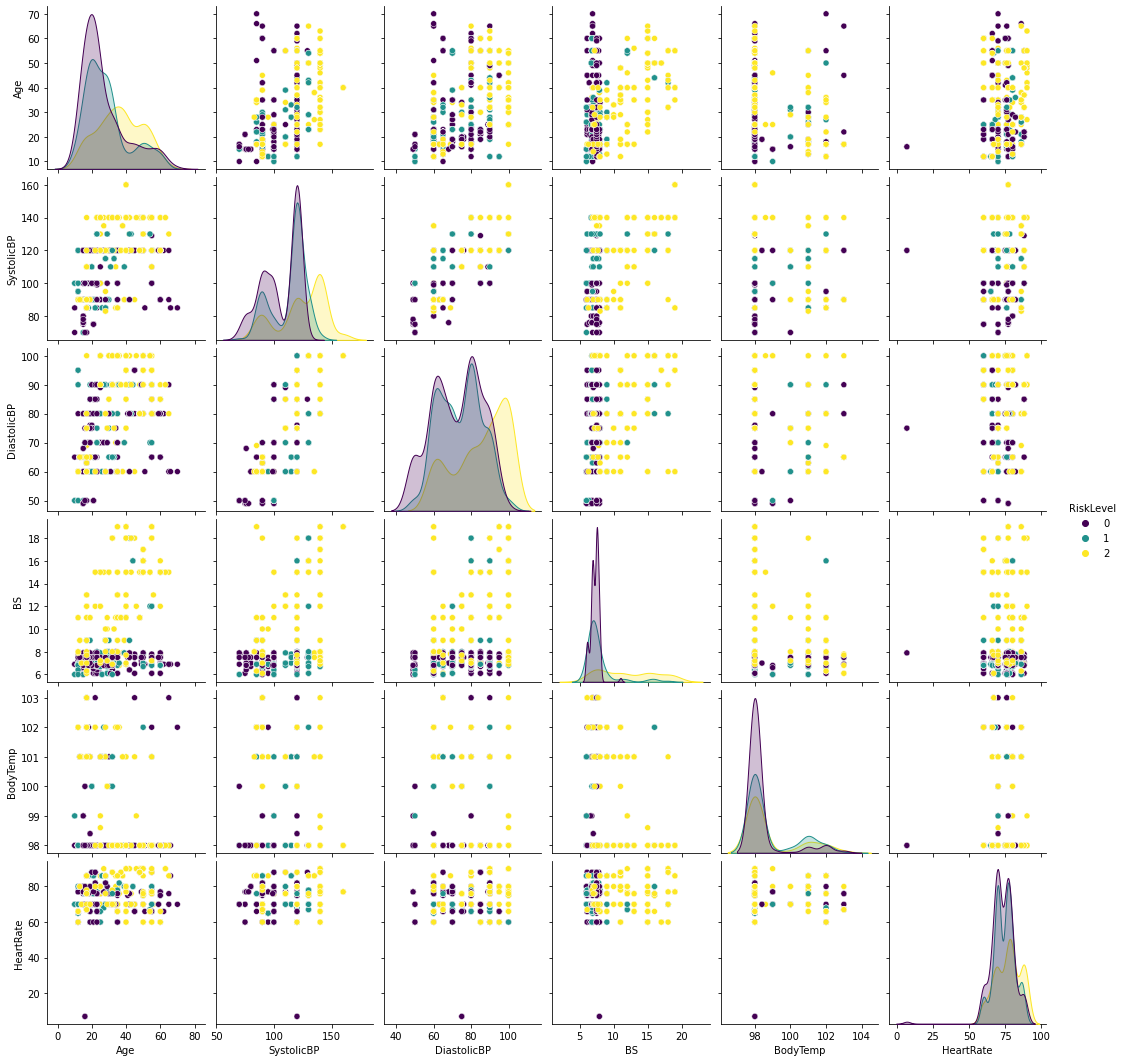

In [ ]:
import pandas as pd
import seaborn as sns

# Load the data
data = pd.read_csv("AIData.csv")

# data cleaning
data = data.dropna()  # Remove missing values
maprisklevel = {'low risk': 0, 'mid risk': 1, 'high risk': 2} #encode risk as numbers
data['RiskLevel'] = data['RiskLevel'].map(maprisklevel)

# Pair plot with risk level as hue
sns.pairplot(data, hue='RiskLevel', palette="viridis") 
plt.show()


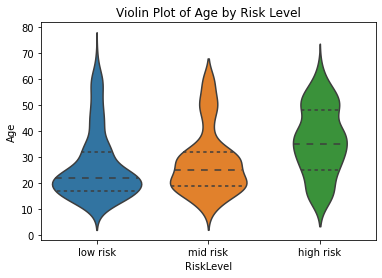

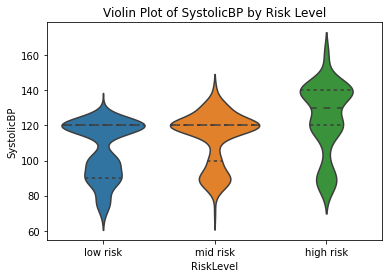

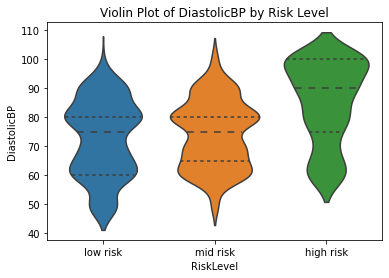

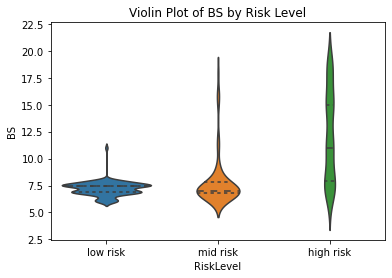

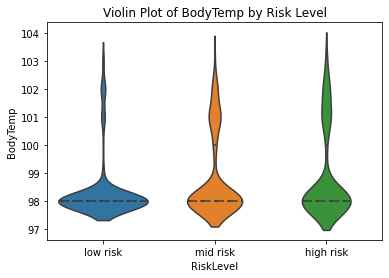

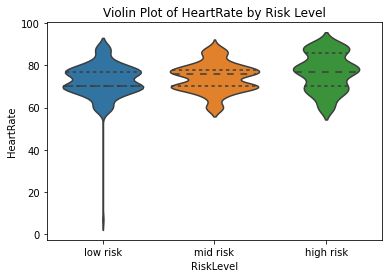

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the data
data = pd.read_csv("AIData.csv")

# Data cleaning
data = data.dropna()  # Remove missing values
maprisklevel = {'low risk': 0, 'mid risk': 1, 'high risk': 2} #encode risk as number
data['RiskLevel'] = data['RiskLevel'].map(maprisklevel)

# Violin plots for each feature by risk level
numericfeat = data.select_dtypes(include=np.number).columns.tolist()
numericfeat.remove('RiskLevel')

for feature in numericfeat: #create violin plot
    sns.violinplot(x='RiskLevel', y=feature, data=data, inner="quartile")
    plt.xticks(ticks=[0, 1, 2], labels=['low risk', 'mid risk', 'high risk'])
    plt.title(f"Violin Plot of {feature} by Risk Level") #compares risk with features.
    plt.show()
